# Project description

The aim of this project is to build machine learning classifiers based on the [Adult Dataset](https://archive.ics.uci.edu/ml/datasets/adult). kNN, classification trees, random forest and Muli-Layer Perceptron models will be trained to predict whether a person income is more than US$50k/year or not. The accuracy, precision and recall for each classifier will be compared.

The Adult Dataset consists of 48842 observations (with missing data) and 14 features. The UCI Repository already provides files for the training and testing sets (2/3 and 1/3 of total observations, respectively).

## Tasks

Practice: Classifiers for the Adult Dataset

1. Get the dataset Adult (either in the UCI Repository or in Kaggle).

2. Analyze features, missing data, and overall characteristics of the dataset (using tools in sklearn). Select features, discretize numerical features, handle missing data. 

3. Build a kNN classifier to predict class variable ">50k" (that is, whether person gets more than US$50k/year or not). Select the hyperparameter using cross-validation; test the final classifier using a holdout dataset.

4. Repeat (3) using either a classification tree or a random forest.

5. Present accuracy, precision and recall for the best classifier in (3) and in (4).

6. Repeat (3) using a Multi-Layer Perceptron. 

# Exploratory data analysis

In this step, we will understand the dataset, check for existing missing data, outliers in countinuous variables and produce exploratory plots.

In [1]:
# Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.pyplot import rcParams

import seaborn as sns

import sklearn
from sklearn import preprocessing, metrics
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_roc_curve, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

In [2]:
# Loading the training dataset
df_train = pd.read_csv('./dataset/adult_data.csv', header=None)

In [3]:
df_train.shape # 32561 observations and 14 features 

(32561, 15)

In [4]:
df_train.head(5)

0                 1       2          3   4                   5   \
0  39         State-gov   77516  Bachelors  13       Never-married   
1  50  Self-emp-not-inc   83311  Bachelors  13  Married-civ-spouse   
2  38           Private  215646    HS-grad   9            Divorced   
3  53           Private  234721       11th   7  Married-civ-spouse   
4  28           Private  338409  Bachelors  13  Married-civ-spouse   

                  6              7      8       9     10  11  12  \
0       Adm-clerical  Not-in-family  White    Male  2174   0  40   
1    Exec-managerial        Husband  White    Male     0   0  13   
2  Handlers-cleaners  Not-in-family  White    Male     0   0  40   
3  Handlers-cleaners        Husband  Black    Male     0   0  40   
4     Prof-specialty           Wife  Black  Female     0   0  40   

              13     14  
0  United-States  <=50K  
1  United-States  <=50K  
2  United-States  <=50K  
3  United-States  <=50K  
4           Cuba  <=50K

In [5]:
# Loading the test dataset
df_test = pd.read_csv('./dataset/adult_test.csv', header=None)

In [6]:
df_test.shape # 16281 observations and 14 features

(16281, 15)

In [7]:
df_test.head(5)

0          1       2             3   4                   5   \
0  25    Private  226802          11th   7       Never-married   
1  38    Private   89814       HS-grad   9  Married-civ-spouse   
2  28  Local-gov  336951    Assoc-acdm  12  Married-civ-spouse   
3  44    Private  160323  Some-college  10  Married-civ-spouse   
4  18          ?  103497  Some-college  10       Never-married   

                  6          7      8       9     10  11  12             13  \
0  Machine-op-inspct  Own-child  Black    Male     0   0  40  United-States   
1    Farming-fishing    Husband  White    Male     0   0  50  United-States   
2    Protective-serv    Husband  White    Male     0   0  40  United-States   
3  Machine-op-inspct    Husband  Black    Male  7688   0  40  United-States   
4                  ?  Own-child  White  Female     0   0  30  United-States   

       14  
0  <=50K.  
1  <=50K.  
2   >50K.  
3   >50K.  
4  <=50K.

Although UCI Repository already provides the dataset splited into training and testing, in this project the two subsets will be concatenated and splited again after the preprocessing steps.

In [8]:
# The dataset will be splited into training and test after the preprocessing step
df = pd.concat([df_train, df_test])
df.shape

(48842, 15)

In [9]:
# Change colnames
df = df.rename(columns={
    0:"age",
    1:"workclass",
    2:"fnlwgt",
    3:"education",
    4:"education-num",
    5:"matrial-status",
    6:"occupation",
    7:"relationship",
    8:"race",
    9:"sex",
    10:"capital-gain",
    11:"capital-loss",
    12:"hours-per-week",
    13:"native-country",
    14:"income"
})

With the function dtypes we can check the type of each feature in the dataset.

In [10]:
# Verify the class of each feature
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
matrial-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

The dataset has 6 numeric features (age, fnlwgt, education-num, capital-gain, capital-loss and hours-per-week) and 8 categorial features (workclass, education, matrial-status, occupation, relationship, race, sex, native-country and income)


## Categorical variables

Let's explore the categorical attributes, verifying their levels and respective frequencies.

In [11]:
[print(f"\n## {column} ##\n{df[column].value_counts(normalize=True)*100}") for column in df.select_dtypes(include=['object'])]


## workclass ##
Private             69.419762
Self-emp-not-inc     7.907129
Local-gov            6.420703
?                    5.730724
State-gov            4.055935
Self-emp-inc         3.470374
Federal-gov          2.931903
Without-pay          0.042996
Never-worked         0.020474
Name: workclass, dtype: float64

## education ##
HS-grad         32.316449
Some-college    22.271815
Bachelors       16.430531
Masters          5.439990
Assoc-voc        4.219729
11th             3.709922
Assoc-acdm       3.277917
10th             2.843864
7th-8th          1.955284
Prof-school      1.707547
9th              1.547848
12th             1.345154
Doctorate        1.216166
5th-6th          1.042136
1st-4th          0.505712
Preschool        0.169936
Name: education, dtype: float64

## matrial-status ##
Married-civ-spouse       45.819172
Never-married            32.998239
Divorced                 13.580525
Separated                 3.132550
Widowed                   3.107981
Married-spouse-abse

[None, None, None, None, None, None, None, None, None]

Apparently, missing data in categorical attributes are reported as "?". 

It's also possible to verify that the variable of interest (income) has some typo errors that need to be corrected (e.g.: some observations reported income as <=50K. but it's the same as <=50K)

The feature "native-country" has some unbalanced representation of labels.

Let's check if there are missing data reported as NA:

In [12]:
df.isna().any()

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
matrial-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
income            False
dtype: bool

The missing data was reported only as "?" and will be removed.

Let's correct the typo error for the "income" feature and convert it into a binary feature, so we can analyze the relationship with other features.

In [13]:
df = df.replace('<=50K.', '<=50K')
df = df.replace('>50K.', '>50K')

df['income'].unique()

array(['<=50K', '>50K'], dtype=object)

In [14]:
df['income']=df['income'].map({'<=50K': 0, '>50K': 1})

In [15]:
df['income'].value_counts(normalize=True)

0    0.760718
1    0.239282
Name: income, dtype: float64

Now, we can explore the relationship between the categorical variables and the feature of interest with the catplot function from seaborn library. In all cases, we will consider the proportion of observations in each category who earns more than 50K/year. 

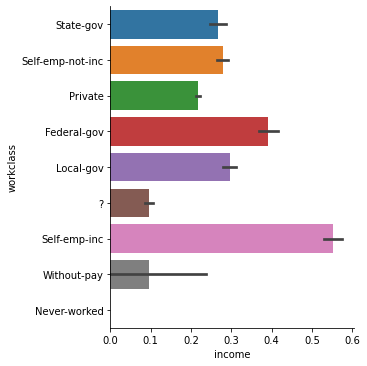

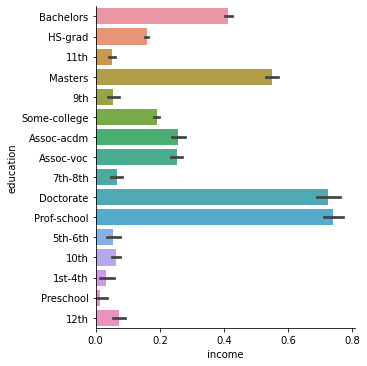

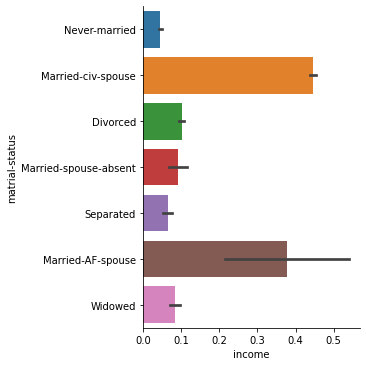

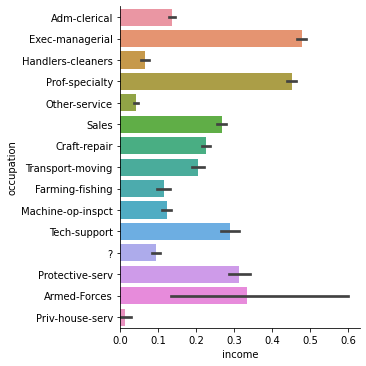

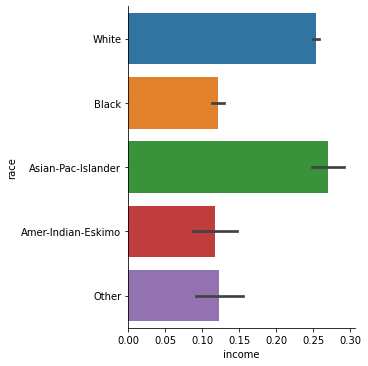

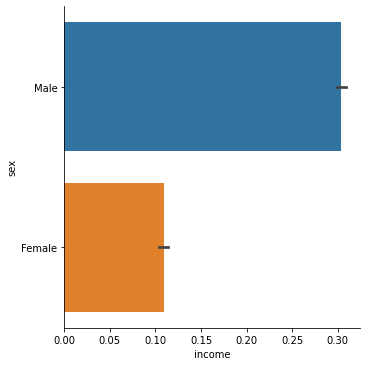

In [16]:
sns.catplot(x='income', y='workclass', kind="bar", data=df)
sns.catplot(x='income', y='education', kind="bar", data=df)
sns.catplot(x='income', y='matrial-status', kind="bar", data=df)
sns.catplot(x='income', y='occupation', kind="bar", data=df)
sns.catplot(x='income', y='race', kind="bar", data=df)
sns.catplot(x='income', y='sex', kind="bar", data=df)

Apparently, all the categorical variables have a relation with the income feature. 

## Numeric variables

Next, let's check for outliers and data distribution for the numeric features

In [17]:
    df.describe()

age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week        income  
count    48842.000000  48842.000000  
mean        40.422382      0.239282  
std         12.391444      0.426649  
min          1.000000      0.000000  
25%         40.000000      0.000000  
50%         40.000000      0.000000  
75%         45.000000      0.000000  
max         99.000000      1.000000

Apparently, there are outliers reported in the features "capital-gain" and "hours-per-week". We can also see that the "capital-gain" and "capital-loss" fetures are sparse variables with a lot of 0 occurencies and dissonant maximum and mean values.

Let's check the boxplots and histograms for each numeric feature.

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>],
       [<AxesSubplot:title={'center':'education-num'}>,
        <AxesSubplot:title={'center':'capital-gain'}>],
       [<AxesSubplot:title={'center':'capital-loss'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>]], dtype=object)

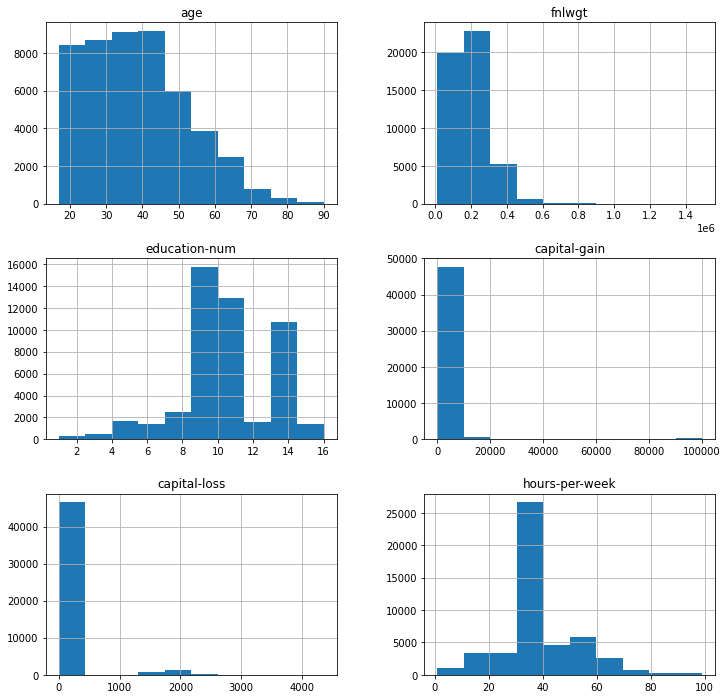

In [18]:
# Visualize numerical values distribution by histograms
rcParams['figure.figsize'] = 12, 12
df[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']].hist()

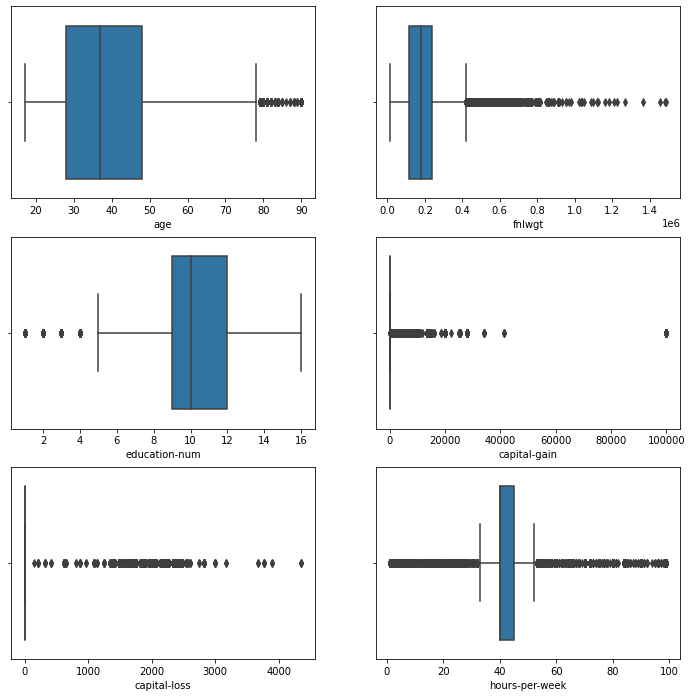

In [19]:
# Visualize numerical values distribution by boxplots

cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']

for i in range(0,6):
    plt.subplot(3,2,i+1)         # Create subplots on a grid with 3 rows and 2 columns
    sns.boxplot(x=df[cols[i]])

plt.show()

By the histogram and boxplots analysis, it's possible to note that there are outliers reported in the "capital-gain" and "hours-per-week" features. Observations who reported more than 80 hours worked per week or more than 80k as capital gain will be considered as outliers and removed.

Let's check the correlation between the numeric variables and the feature of interest.

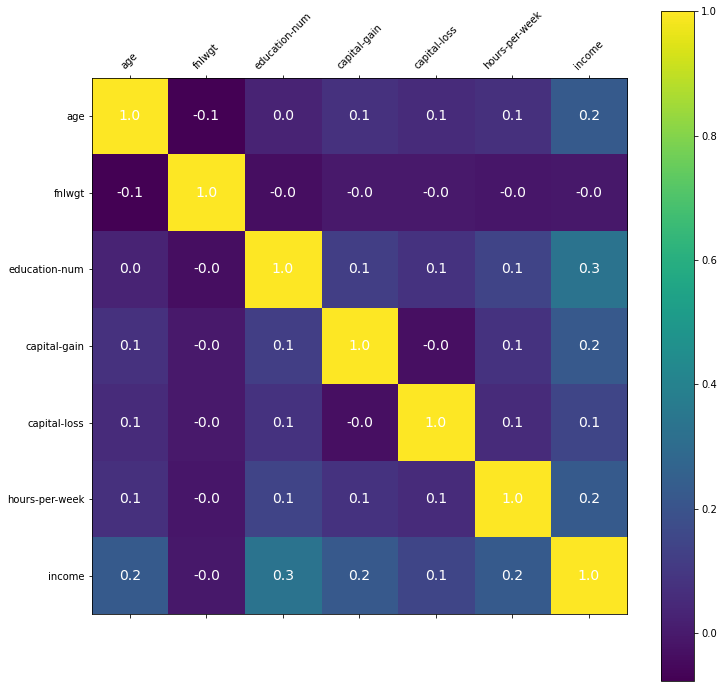

In [20]:
# Ploting the correlation between the feature of interest to be predicted (income) and individual numeric features

plt.matshow(df.corr())
plt.colorbar()
plt.xticks(np.arange(len(df.corr().columns)), df.corr().columns.values, rotation = 45) 
plt.yticks(np.arange(len(df.corr().columns)), df.corr().columns.values) 
for (i, j), corr in np.ndenumerate(df.corr()):
    plt.text(j, i, '{:0.1f}'.format(corr), ha='center', va='center', color='white', fontsize=14)

By the correlation matrix, it's possible to see that years of education, worked hours per week and age have more correlation with the income, while  fnlwgt has 0 correlation and can be removed from the analysis.

# Preprocessing data

In the exploratory analysis step, we checked for outliers in countinuous variables and reported missing data. As the first step of the preprocessing operations, we will remove the missing data and outliers.

### Handling with missing data and outliers

First, let's replace variables reported as unknown values ("?") for NaN and then drop out the observations with NaN values.

In [21]:
# Replace variables reported as unknown values ("?") for NaN
df = df.replace('?', np.NaN)

In [22]:
df.isna().any()

age               False
workclass          True
fnlwgt            False
education         False
education-num     False
matrial-status    False
occupation         True
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country     True
income            False
dtype: bool

In [23]:
# Remove missing data
df = df.dropna()
df.isna().any()

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
matrial-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
income            False
dtype: bool

In [24]:
df.shape # 3620 observations removed

(45222, 15)

7.4% of the observations had missing values and were removed. After drop out missing values, the dataset has now 45222 observations.

Next, we will remove observations who reported worked hours per week greater than 80h and capital-gain greater than 80K.

In [25]:
# Remove outliers in the capital-gain variable
df = df[df['capital-gain'] < 80000]

In [26]:
df.shape # 229 observations removed

(44993, 15)

In [27]:
# Remove outliers in the hours-per-week variable
df = df[df['hours-per-week'] < 80]

In [28]:
df.shape # 475 observations removed

(44518, 15)

1.58% of the observations were considered outliers and removed. After dropping out outliers, the dataset has now 44518 observations.

### Feature Selection and Feature Engineering.

After removing outliers and missing data, our dataset has 44518 observarions and 14 features. In this step, we will check if all the 13 features are necessary to predict the income variable

In [29]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'matrial-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

The features "education" and "education-num" holds the same information but one is coded as years in school and the other is a categorical value with the highest degree obtained by a person. Let's keep just the feature "education-num".

The same redudancy is observed in the features "matrial-status" and "relationship", so let's keep just the "matrial-status" feature.

As the feature "fnlwgt" has no correlation with the feature of interest, we will also discard it.

In [30]:
# Removing features
df = df.drop(['education', 'relationship', 'fnlwgt'], axis = 1)

The feature "native-country" has some unbalanced labels that can be improved by grouping some items.

In [31]:
df['native-country'].value_counts(normalize=True)

United-States                 0.912777
Mexico                        0.020104
Philippines                   0.006222
Germany                       0.004335
Puerto-Rico                   0.003909
Canada                        0.003639
El-Salvador                   0.003302
India                         0.003190
Cuba                          0.002965
England                       0.002628
China                         0.002516
Jamaica                       0.002291
South                         0.002224
Italy                         0.002201
Dominican-Republic            0.002134
Japan                         0.001932
Guatemala                     0.001932
Vietnam                       0.001842
Poland                        0.001819
Columbia                      0.001797
Haiti                         0.001550
Portugal                      0.001370
Iran                          0.001258
Taiwan                        0.001191
Nicaragua                     0.001078
Greece                   

In [32]:
# Grouping labels into Asian countries
df['native-country'] = df['native-country'].replace(['Cambodia',
'India','Iran','Japan','Laos','Philippines','Taiwan','Thailand',
'Vietnam','Hong','China'],'Asian')

# Grouping labels into European countries
df['native-country'] = df['native-country'].replace(['England','France',
'Germany','Greece','Holand-Netherlands','Hungary','Ireland','Italy',
'Poland', 'Portugal','Scotland','Yugoslavia'],'European')

# Grouping labels into Latin-America countries
df['native-country'] = df['native-country'].replace(['Columbia','Cuba',
'Dominican-Republic','Ecuador','El-Salvador','Guatemala','Haiti',
'Honduras','Jamaica','Mexico','Nicaragua','Peru','Puerto-Rico','South',
'Trinadad&Tobago'],'Latin-America')

# Grouping Outlying-US(Guam-USVI-etc) as US
df['native-country'] = df['native-country'].replace('Outlying-US(Guam-USVI-etc)', 'United-States')

In [33]:
df['native-country'].value_counts(normalize=True)

United-States    0.913271
Latin-America    0.046273
Asian            0.020464
European         0.016353
Canada           0.003639
Name: native-country, dtype: float64

In [34]:
df.head()

age         workclass  education-num      matrial-status  \
0   39         State-gov             13       Never-married   
1   50  Self-emp-not-inc             13  Married-civ-spouse   
2   38           Private              9            Divorced   
3   53           Private              7  Married-civ-spouse   
4   28           Private             13  Married-civ-spouse   

          occupation   race     sex  capital-gain  capital-loss  \
0       Adm-clerical  White    Male          2174             0   
1    Exec-managerial  White    Male             0             0   
2  Handlers-cleaners  White    Male             0             0   
3  Handlers-cleaners  Black    Male             0             0   
4     Prof-specialty  Black  Female             0             0   

   hours-per-week native-country  income  
0              40  United-States       0  
1              13  United-States       0  
2              40  United-States       0  
3              40  United-States       0  
4              40  Latin-America       0

In [35]:
df.shape

(44518, 12)

### Data normalization

After removing outliers, missing values, solving unbalanced labels and selecting the relevant features for predict the income variable, our dataset has 44518 observations in 12 features (11 independent and 1 dependent). The data is almost ready to train the models, but before it's necessary to normalize the data and transform categorical features into numeric.

In [36]:
# Transforming categorical variables into numeric with sklearn
cat = ['workclass','matrial-status', 'occupation', 'race', 'sex','native-country']

for f in cat:
        le = preprocessing.LabelEncoder()
        df[f] = le.fit_transform(df[f])


In [37]:
df.head(10)

age  workclass  education-num  matrial-status  occupation  race  sex  \
0   39          5             13               4           0     4    1   
1   50          4             13               2           3     4    1   
2   38          2              9               0           5     4    1   
3   53          2              7               2           5     2    1   
4   28          2             13               2           9     2    0   
5   37          2             14               2           3     4    0   
6   49          2              5               3           7     2    0   
7   52          4              9               2           3     4    1   
8   31          2             14               4           9     4    0   
9   42          2             13               2           3     4    1   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40               4       0  
1             0             0              13               4       0  
2             0             0              40               4       0  
3             0             0              40               4       0  
4             0             0              40               3       0  
5             0             0              40               4       0  
6             0             0              16               3       0  
7             0             0              45               4       1  
8         14084             0              50               4       1  
9          5178             0              40               4       1

As verified in the exploratory analysis steps, we have some numeric features that are sparce and can't be normalized by linear transformations or z-score, since these techniques are senstive to extreme values. So for the features "capital-gain" and "capital-loss" the normalization will be done using the RobustScaler method from sklearn, which scale features using statistics that are robust to outliers. 

Before, we will split the data into training (2/3) and testing (1/3).

In [38]:
# Splitting the data set into features and outcome

X = df.drop(['income'], axis=1)
Y = df['income']

In [39]:
# Splitting the data into test data and training data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

In [40]:
X_train.head()

age  workclass  education-num  matrial-status  occupation  race  sex  \
29973   20          2             10               4           7     4    0   
5553    18          2              7               4          11     4    1   
23919   46          2             10               2           0     4    0   
12342   22          2              9               4          12     4    0   
3231    47          2              9               5           8     2    0   

       capital-gain  capital-loss  hours-per-week  native-country  
29973             0             0              25               4  
5553              0             0              20               4  
23919             0             0              40               4  
12342             0             0              40               4  
3231              0             0              50               3

In [41]:
# dense numeric features
dense_num_features = ["age", "education-num", "hours-per-week"]
std_scaler = StandardScaler()

X_train[dense_num_features] = std_scaler.fit_transform(X_train[dense_num_features])
X_test[dense_num_features] = std_scaler.fit_transform(X_test[dense_num_features])

<ipython-input-41-98880e0d7fd6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[dense_num_features] = std_scaler.fit_transform(X_train[dense_num_features])
/home/catarina/Documents/Doutorado/Disciplinas/2021_01/PCS5024/PCS5024/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-41-98880e0d7fd6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [42]:
X_train.head()

age  workclass  education-num  matrial-status  occupation  race  \
29973 -1.398112          2      -0.045014               4           7     4   
5553  -1.549543          2      -1.225759               4          11     4   
23919  0.570487          2      -0.045014               2           0     4   
12342 -1.246682          2      -0.438596               4          12     4   
3231   0.646202          2      -0.438596               5           8     2   

       sex  capital-gain  capital-loss  hours-per-week  native-country  
29973    0             0             0       -1.394311               4  
5553     1             0             0       -1.848519               4  
23919    0             0             0       -0.031688               4  
12342    0             0             0       -0.031688               4  
3231     0             0             0        0.876728               3

In [43]:
X_test.head()

age  workclass  education-num  matrial-status  occupation  race  \
5784  -0.865846          2       1.150162               4           3     4   
27028  0.338417          2       1.150162               2           6     4   
13232  0.714749          2      -1.994799               2           2     4   
8928  -0.790579          2       1.150162               2           3     4   
24289  0.338417          5      -0.029198               0           0     2   

       sex  capital-gain  capital-loss  hours-per-week  native-country  
5784     0             0             0       -0.043487               4  
27028    1             0          1887       -0.043487               4  
13232    1             0             0        0.322319               4  
8928     0             0             0        0.871027               4  
24289    1             0             0        0.871027               4

In [48]:
# sparse numeric features
sparse_num_features = ["capital-gain", "capital-loss"]
r_scaler = RobustScaler()

X_train[sparse_num_features] = r_scaler.fit_transform(X_train[sparse_num_features])
X_test[sparse_num_features] = r_scaler.fit_transform(X_test[sparse_num_features])

<ipython-input-48-d36d14bda1cd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[sparse_num_features] = r_scaler.fit_transform(X_train[sparse_num_features])
/home/catarina/Documents/Doutorado/Disciplinas/2021_01/PCS5024/PCS5024/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-48-d36d14bda1cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

# Prediction

After the preprocessing steps and having our dataset splited into training and testing data, we can start with the prediction models.

## K-NN

The first classifier will be the K-Nearest Neighbors (K-NN). The K-NN calculates the distance of a new data point (usually, euclidian distance) to all other training data points and assigns the new data point to the class to which the majority of the K neighbors below to. It's necessary to define a hyperparameter for this model, that is the number of neighbors (k) to be used. 

To evaluate the best K possible, we will use cross-validation inside the training database. We will use cross_val_score function from sklearn, using 5-fold cross validation and evaluate the best K by the accuracy mean.

In [754]:
# Number of neighbors to be tested
neighbors = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

# Dict to store the accuracy for each k-n
neighbors_scores = {}

In [755]:
for n_neighbors in neighbors:
    # Get the mean accuracy for each model
    score = cross_val_score(KNeighborsClassifier(n_neighbors=n_neighbors), X_train, Y_train, cv = 5, scoring="accuracy").mean() #cv = 5 uses 5-fold cross validation
    
    # Store accuracy
    neighbors_scores[n_neighbors] = score

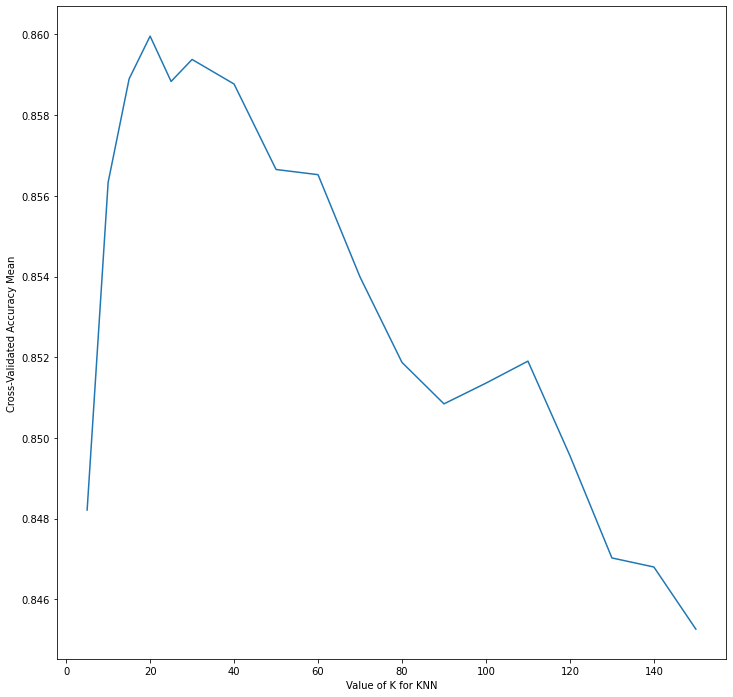

In [756]:
# Plot to see the accuracy of different k-neighbors

lists = sorted(neighbors_scores.items()) # sort dict by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy Mean')
plt.show()

The best K number for the KNN algorithm is 20, with a 86% of accuracy.

Now we can build a KNN classifier with K=20 on the training database and then test it on the testing database.

In [59]:
# Training the model

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=20)

In [742]:
#Predict the Y values for X variables in the test set

knn_y_predictions = knn.predict(X_test)

In [752]:
# Get accuracy, precision and recall

print("\nAccuracy is ", accuracy_score(Y_test,knn_y_predictions)*100)


Accuracy is  86.02875112309074


In [816]:
# Plot Confusion Matrix
print(confusion_matrix(Y_test,knn_y_predictions))

[[9462  655]
 [1211 2028]]


For the KNN Algorithm:

True positive is 9462.
True negative is 2028.
False positive is 655.
False negative is 1211.

In [818]:
# Precision
knn_precision = (9462)/(9462+655)
knn_precision

0.9352574873974498

In [820]:
# Recall 
knn_recall = (9462)/(9462+1211)
knn_recall

0.8865361191792374

## Random Forest

The second classifier will be the Random Forest. A random forest is a classifier that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. 

The random forest classifier requires the number of trees in the forest as hyperparameter. To evaluate the hyperparameter, we will use cross-validation inside the training database using 5-fold cross validation and evaluate the best hyperparameter by the accuracy mean.

In [776]:
# Number of trees to be tested
tree = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230]

# Dict to store the accuracy for each tree number
tree_scores = {}

In [777]:
for n_trees in tree:
    # Get the mean accuracy for each model
    score = cross_val_score(RandomForestClassifier(n_estimators=n_trees), X_train, Y_train, cv = 5, scoring="accuracy").mean() #cv = 5 uses 5-fold cross validation
    
    # Store accuracy
    tree_scores[n_trees] = score

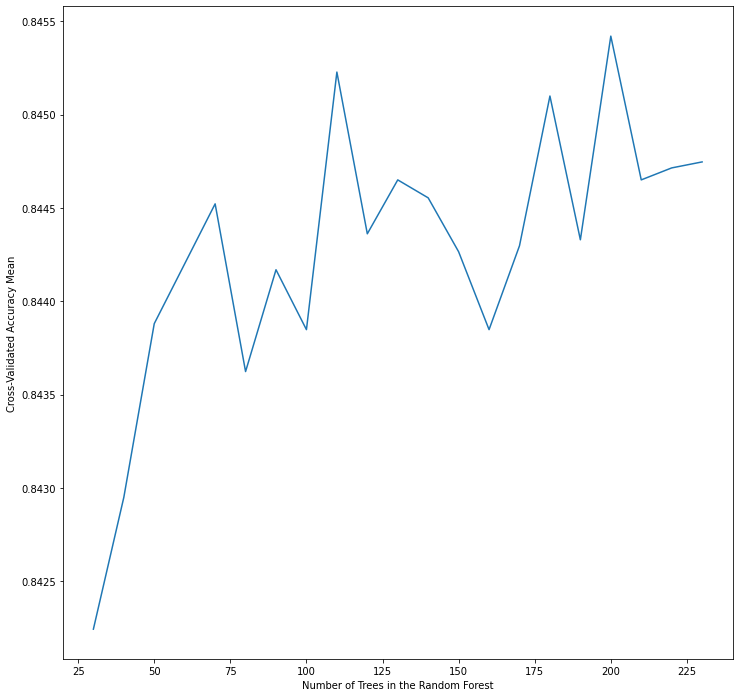

In [778]:
# Plot to see the accuracy for different number of trees

lists = sorted(tree_scores.items()) # sort dict by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.xlabel('Number of Decision Trees in the Random Forest')
plt.ylabel('Cross-Validated Accuracy Mean')
plt.show()

The best number of Decision Trees for the random forest algorithm is 200, with a 84.55% of accuracy.

Now we can build a Random Forest classifier with 200 decision trees on the training database and then test it on the testing database.

In [60]:
# Training the model

rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=200)

In [790]:
#Predict the Y values for X variables in the test set

rf_y_predictions = rf.predict(X_test)

In [791]:
# Get accuracy, precision and recall

print("\nAccuracy is ", accuracy_score(Y_test,rf_y_predictions)*100)


Accuracy is  84.80083857442348


In [807]:
# Plot Confusion Matrix
print(confusion_matrix(Y_test,rf_y_predictions))

[[9347  770]
 [1260 1979]]


For the Random Forest Algorithm:

True positive is 9347.
True negative is 1979.
False positive is 770.
False negative is 1260.

In [809]:
# Precision
rf_precision = (9347)/(9347+770)
rf_precision

0.9238904813679945

In [811]:
# Recall
rf_recall = (9347)/(9347+1260)
rf_recall

0.8812105213538229

## Multi-Layer Perceptron

The last classifier will be the Multi-Layer Perceptron (MLP). The MLP is an Artificial Neural Network based algorithm. An MLP consists of at least three layers of nodes: an input layer to insert the features in the neural Network, one or more hidden layers with the neurons and an output layer. Except for the input nodes, each node is a neuron that uses a activation function to distinguish data into classes.

The MLP can use as hyperparameters the size of the hidden layers, the learning rate of the algorithm. To evaluate the best hyperparameters possibleross-validation inside the training database. We will use RandomizeSearchCV function from sklearn, using 5-fold cross validation and evaluate the best hyperparameters by the accuracy mean.

In [795]:
mlp = MLPClassifier(random_state=42, early_stopping=True)

In [796]:
hyperparams = {'hidden_layer_sizes': [(2 ** i, 2 ** j) for j in np.arange(5, 8) for i in np.arange(4, 7)],
               'learning_rate': ['constant','adaptive']}

# Search for the best hyperparameters
mlp_search_cv = RandomizedSearchCV(mlp, hyperparams, scoring='accuracy', n_iter=25, cv=3, n_jobs=-1, random_state=42)
%timeit -n 1 -r 1 mlp_search_cv.fit(X_train, Y_train)

/home/catarina/Documents/Doutorado/Disciplinas/2021_01/PCS5024/PCS5024/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 18 is smaller than n_iter=25. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
6min 14s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best hyperparameters: {'learning_rate': 'constant', 'hidden_layer_sizes': (64, 64)}
Accuracy of the best model: 0.83647


In [799]:
print('Best hyperparameters: {}'.format(mlp_search_cv.best_params_))
print('Accuracy of the best model: {}'.format(round(mlp_search_cv.best_score_,5)))

Best hyperparameters: {'learning_rate': 'constant', 'hidden_layer_sizes': (64, 64)}
Accuracy of the best model: 0.83647


In [61]:
# Training the model

mlp = MLPClassifier(hidden_layer_sizes=(64,64), learning_rate='constant')  
mlp.fit(X_train, Y_train)

MLPClassifier(hidden_layer_sizes=(64, 64))

In [802]:
#Predict the Y values for X variables in the test set

mlp_y_predictions = mlp.predict(X_test)

In [803]:
# Get accuracy, precision and recall

print("\nAccuracy is ", accuracy_score(Y_test, mlp_y_predictions)*100)


Accuracy is  84.32914046121593


In [821]:
# Plot Confusion Matrix

print(confusion_matrix(Y_test,mlp_y_predictions))

[[9562  555]
 [1538 1701]]


For the MLP Algorithm:

True positive is 9562.
True negative is 1701.
False positive is 555.
False negative is 1538.

In [822]:
# Precision
mlp_precision = (9562)/(9562+555)
mlp_precision

0.9451418404665415

In [824]:
# Recall
mlp_recall = (9562)/(9562+1538)
mlp_recall

0.8614414414414414

# Additional Classifiers

## Logistic Regression

It's a linear classifier for binary outcomes that aims to find the logistic regression function 𝑝(𝐱) such that the predicted responses 𝑝(𝐱ᵢ) are as close as possible to the actual response 𝑦ᵢ for each observation. To find the best function p(x) it's necessary to predict the best wheights for each independent variable, usually by maximizing the log-likelihood function (LLF).

Logistic regression requires the dependent variable to be binary and the independent variables should be independent of each other. That is, the model should have little or no multicollinearity.

In [55]:
# Initialize model.
logreg = LogisticRegression()

logreg.fit(X_train, Y_train)

/home/catarina/Documents/Doutorado/Disciplinas/2021_01/PCS5024/PCS5024/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [56]:
y_logreg_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, Y_test)))

Accuracy of logistic regression classifier on test set: 0.82


In [64]:
# Plot the confusion matrix

print(confusion_matrix(Y_test, y_logreg_pred))


[[9497  620]
 [1820 1419]]


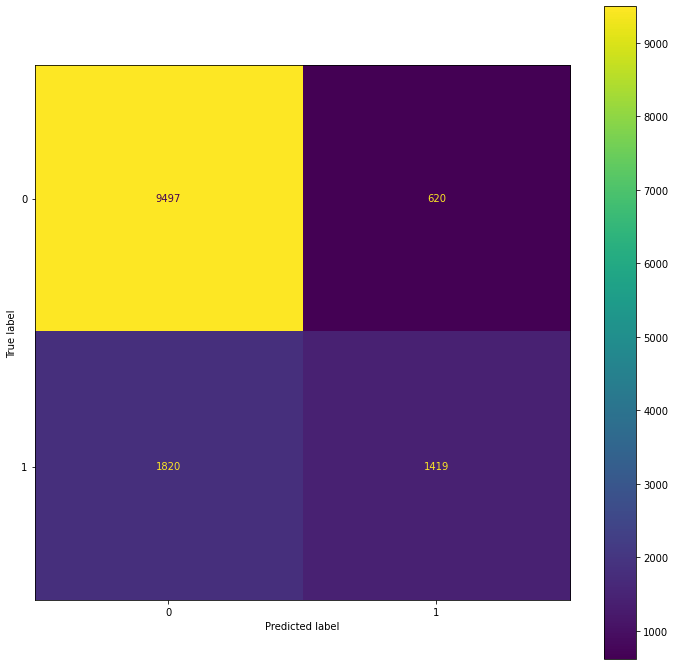

In [69]:
plot_confusion_matrix(logreg, X_test, Y_test) 

For the Logistic Regression algorithm:

True positive is 1419.
True negative is 9497.
False positive is 620.
False negative is 1820.

In [61]:
print(classification_report(Y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     10117
           1       0.70      0.44      0.54      3239

    accuracy                           0.82     13356
   macro avg       0.77      0.69      0.71     13356
weighted avg       0.80      0.82      0.80     13356



In [71]:
#Precision
round(1419/(1419+620), 2)

0.7

In [73]:
#Recall 
round(1419/(1419+1820),2)

0.44

## SVM

Support Vector Machine is a classifier based on the concept of ‘decision planes’, where hyperplanes are used to classify a set of objects. The aim of SVM are to choose a hyperplane with maximum margin (maximum distance from the hyperplane to the closest training point). Adaptations of the original SVM allows the classification of non-linearly separable datasets using Kernel SVM. Kernel SVM projects the non-linearly separable datasets of lower dimensions to linearly separable data of higher dimension

In [64]:
#svm = SVC()
#C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
#kernel=['rbf','linear']
#hyper={'kernel':kernel,'C':C} #setting hyperparameters

#svm_search_cv=GridSearchCV(estimator=svm,param_grid=hyper,verbose=True)
#svm_search_cv.fit(X_train, Y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
#print(svm_search_cv.best_estimator_)

In [ ]:
#print(svm_search_cv.best_score_)

In [ ]:
#print(svm_search_cv.best_params_)

In [44]:
svm = SVC(kernel='linear')
svm.fit(X_train, Y_train)

In [ ]:
svm_y_pred = vm.predict(X_test)

## Naive Bayes

Naive Bayes is a classification algorithm that works based on the Bayes theorem. Using Bayes theorem it’s possible to find the probability of an event A, given that B occurred. We are using the Naive Bayes algorithm to find the category of the new data point, that is, if a person’s income is greater or less than U$ 50K/year. 

For this, we have to find the posterior probability of income is more than US$50k/year or not for this data point, given the observed dependent variables (X). After comparing, the point belongs to the category having a higher probability, given their features.

In [48]:
nb = GaussianNB()
nb.fit(X_train, Y_train) # training the model
nb_y_pred  =  nb.predict(X_test) #testing the model
print("\nAccuracy is ", accuracy_score(Y_test, nb_y_pred)*100)


Accuracy is  80.05390835579514


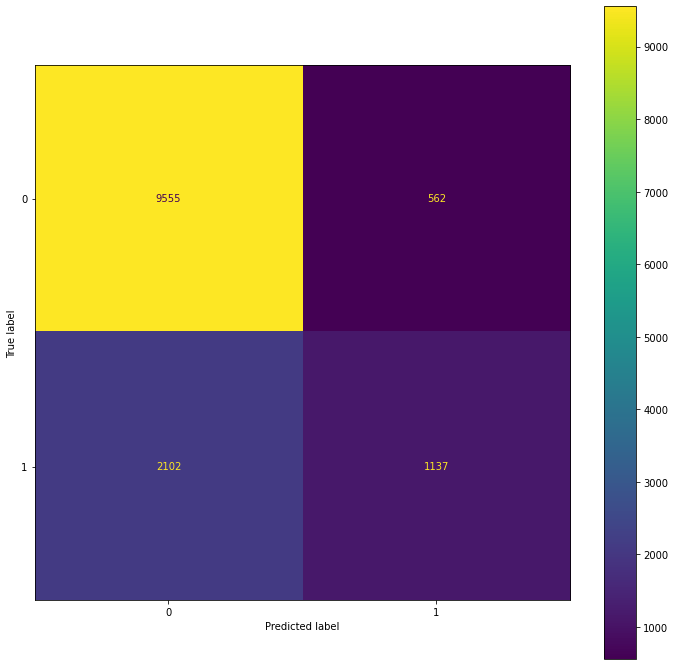

In [49]:
plot_confusion_matrix(nb, X_test, Y_test) # confusion matrix

In [52]:
#Precision
round(1137/(1137+562),2)

0.67

In [53]:
#Recall
round(1137/(1137+2102),2)

0.35

In [50]:

print(classification_report(Y_test, nb_y_pred))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88     10117
           1       0.67      0.35      0.46      3239

    accuracy                           0.80     13356
   macro avg       0.74      0.65      0.67     13356
weighted avg       0.78      0.80      0.78     13356



## Comparing the methods

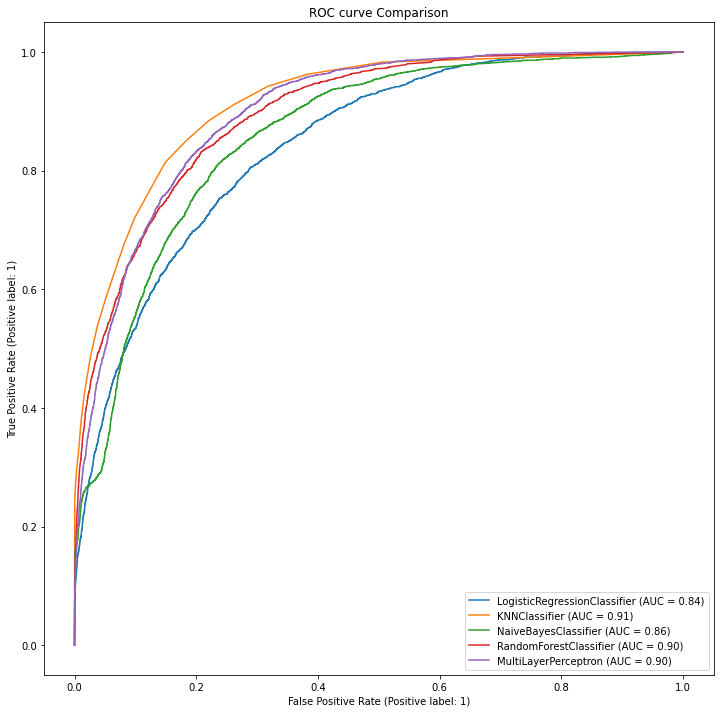

In [63]:
fig, ax = plt.subplots()
plot_roc_curve(logreg, X_test, Y_test, ax=ax, name='LogisticRegressionClassifier')
plot_roc_curve(knn, X_test, Y_test, ax=ax, name='KNNClassifier')
plot_roc_curve(nb, X_test, Y_test, ax=ax, name='NaiveBayesClassifier')
plot_roc_curve(rf, X_test, Y_test, ax=ax, name='RandomForestClassifier')
plot_roc_curve(mlp, X_test, Y_test, ax=ax, name='MultiLayerPerceptron')

ax.set_title('ROC curve Comparison')
plt.show()